In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

## Homework #8

*Please edit the cell below to add your name, NetID, and any group members that you collaborated with on this assignment.* **Complete this section before proceeding to the assignment questions.**

Name: Runze Li  
NetID: rl50xx  
Group Members: None   
***

In [2]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import arviz as az
rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [3]:
# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

<!-- BEGIN QUESTION -->

**Question 1 (30 points).** Multilevel models can be useful for modeling time series.

In a time series, the observations cluster by entities that have continuity through time, such as individuals. Since observations within individuals are likely highly correlated, the multilevel structure can help quite a lot.

You’ll use the data in *Data/Oxboys.csv*, which is 234 height measurements on 26 boys from an Oxford Boys Club, at 9 different (standardized) ages per boy.

You’ll predict height, using age as a predictor, clustered by Subject (individual boy). 


* Fit a model with varying intercepts and slopes (on age), clustered by Subject. This means your model will have as many intercepts and slopes as Subjects in the dataset. 
* **Define population mean parameters for both the intercepts and slopes** as estimating both parameters will be useful for Question 3. 
* Define your model such that you are able to estimate the correlation between intercepts and slopes shared across the Subjects in the dataset.
* Use `pymc.LKJCorr(4)` for the prior of the correlation matrix. 
* **There is no need to perform a prior predictive simulation for this assignment.**

Note: Using a centered parameterization for your model should result in a good posterior approximation, so there is no need to define your model using the non-centering trick (shown in lecture) for this model. 

__Answer:__

We set up the following model:

- $h_i \sim Normal(p_i, \sigma_h)$
- $p_i = \alpha_{S[i]} + \beta_{S[i]} * A$
- $\sigma_h \sim Normal(0, 1)$
- $[\alpha_j, \beta_j] \sim MvNormal([ \bar{\alpha}, \bar{\beta} ], \sum)$
- $\sum = diag([\sigma_a, \sigma_b])~\rho~diag([\sigma_a, \sigma_b]) $
- $\bar{\alpha}, \bar{\beta} \sim Normal(0, 1)$
- $\sigma_a, \sigma_b \sim Exponential(1)$
- $\rho \sim LKJCorr(4)$

In [4]:
# Write code here
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from scipy import stats

In [6]:
df = pd.read_csv("Data/Oxboys.csv", header=0)
df.head()

,Subject,age,height,Occasion
0,1,-1.0000,140.5,1
1,1,-0.7479,143.4,2
2,1,-0.4630,144.8,3
3,1,-0.1643,147.1,4
4,1,-0.0027,147.7,5


In [7]:
S = df.Subject-1
N_subjects = df.Subject.max()-df.Subject.min()+1
A = df.age
H = df.height

In [9]:
with pm.Model() as mSAHcov:
    Rho_ = pm.LKJCorr("corr", n=2, eta=4) # prior for correlation matrix
    Rmat = pm.Deterministic("Rho", pt.stack([[1, Rho_[0]], [Rho_[0], 1]])) # correlation matrix
    sigma_ = pm.Exponential("sigma", 1, shape=2)

    Sigma = pm.math.dot(
                    pm.math.dot(pt.diag(sigma_), Rmat),
                    pt.diag(sigma_)
    )
    
    abar = pm.Normal("abar")
    bbar = pm.Normal("bbar")

    ab_district = pm.MvNormal("ab_district", mu=pt.stack([abar, bbar]), cov=Sigma, shape=(N_subjects, 2)) 
    a = pm.Deterministic("a", ab_district[:, 0]) # intercept
    b = pm.Deterministic("b", ab_district[:, 1]) # slope

    p = pm.Deterministic("p", a[S] + b[S] * A)

    sigma_h = pm.Exponential("sigma_h", 1)

    h_use = pm.Normal("h_use", mu=p, sigma=sigma_h, observed=H)  # observed continuous data

    idata_SAHcov = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [corr, sigma, abar, bbar, ab_district, sigma_h]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 407 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [10]:
az.summary(idata_SAHcov, var_names=["a", "b"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],148.127,0.217,147.788,148.470,0.003,0.002,3852.0,1407.0,1.00
a[1],142.856,0.219,142.503,143.189,0.003,0.002,4214.0,1310.0,1.00
a[2],155.654,0.219,155.311,156.017,0.003,0.002,4297.0,1060.0,1.00
a[3],165.071,0.229,164.699,165.424,0.003,0.002,4961.0,1067.0,1.00
a[4],151.430,0.228,151.044,151.781,0.003,0.002,5009.0,1453.0,1.00
a[5],146.786,0.225,146.420,147.131,0.004,0.003,3906.0,1398.0,1.00
a[6],146.128,0.223,145.807,146.509,0.004,0.002,3966.0,1457.0,1.00
a[7],148.291,0.218,147.900,148.594,0.003,0.002,4049.0,1565.0,1.00
a[8],138.140,0.223,137.795,138.498,0.003,0.002,4511.0,1419.0,1.00
a[9],130.260,0.222,129.910,130.611,0.004,0.003,3698.0,1318.0,1.00


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Provide visualizations** to present the parameter estimates for the intercepts and slopes for the Subjects and **interpret** these estimates. 

*A good way to represent these parameter estimates is with a bar that represents the high density interval for the posterior distribution of the intercept and slope __for each Subject__. You can add then add the posterior mean estimate of the intercept and slope for each Subject to the plot. Examples for plotting these distributions can be found in the lectures such as the plot of the distribution of the probability of survival in each tank from the introduction to multilevel models lecture or the plots of the distributions of the district effects on contraception from the lecture on correlated features.*

_Type your answer here, replacing this text._

In [11]:
# Write code here
post_posterior = az.extract(idata_SAHcov)
a_values = post_posterior.a.values
b_values = post_posterior.b.values

/tmp/ipykernel_498/1656829378.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(a_values.T, hdi_prob=0.89)


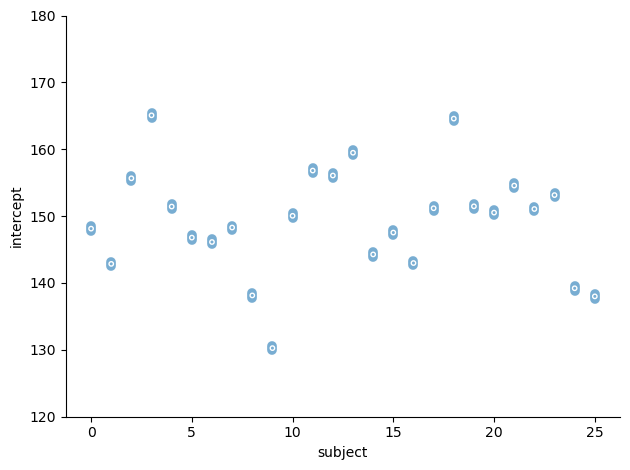

In [12]:
plt.scatter(
    range(a_values.shape[0]),
    np.mean(a_values, axis=1),
    facecolor="none",
    color="white",
    lw=1,
    s=10,
    zorder=3
)
hdis = az.hdi(a_values.T, hdi_prob=0.89)
lines = plt.vlines(
    range(a_values.shape[0]), 
    hdis[:,0], 
    hdis[:,1], 
    # color=colors[i], 
    lw=7, 
    alpha=0.6,
    capstyle="round"
)
plt.scatter(
    range(a_values.shape[0]), 
    a_values.mean(axis=-1),  
    facecolor="none",
    # color=colors[i],
    lw=2,
    s=50
)
plt.axhline(
    y=0.5, 
    color='w', 
    linestyle='--',
    lw=1,
    alpha=0.4
)

plt.ylim(120, 180)
plt.xlabel("subject")
plt.ylabel("intercept")
sns.despine()
plt.tight_layout();

/tmp/ipykernel_498/3059202695.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(b_values.T, hdi_prob=0.89)


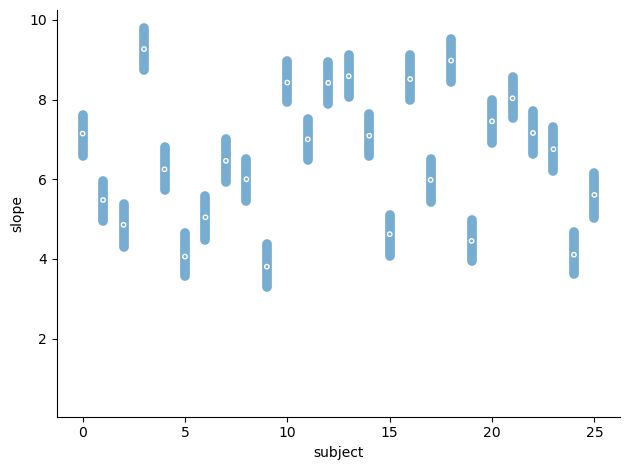

In [13]:
plt.scatter(
    range(b_values.shape[0]),
    np.mean(b_values, axis=1),
    facecolor="none",
    color="white",
    lw=1,
    s=10,
    zorder=3
)
hdis = az.hdi(b_values.T, hdi_prob=0.89)
lines = plt.vlines(
    range(b_values.shape[0]), 
    hdis[:,0], 
    hdis[:,1], 
    # color=colors[i], 
    lw=7, 
    alpha=0.6,
    capstyle="round"
)
plt.scatter(
    range(b_values.shape[0]), 
    b_values.mean(axis=-1),  
    facecolor="none",
    # color=colors[i],
    lw=2,
    s=50
)
plt.axhline(
    y=0.5, 
    color='w', 
    linestyle='--',
    lw=1,
    alpha=0.4
)

plt.xlabel("subject")
plt.ylabel("slope")
sns.despine()
plt.tight_layout();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

* For which parameters (the intercepts or the slopes) does the model have more certainty? **Base your response to this question on posterior estimates for the population intercept standard deviation and the population slope standard deviation.**

__Answer:__

We can see that intercepts have more certainty because the standard deviation of intercepts is smaller than that of slopes.

In [14]:
# Write code here
summary = az.summary(idata_SAHcov, var_names=["a"])
mean_sd_a = summary["sd"].mean()
print(f"Mean of the standard deviation of 'a': {mean_sd_a}")

summary = az.summary(idata_SAHcov, var_names=["b"])
mean_sd_b = summary["sd"].mean()
print(f"Mean of the standard deviation of 'b': {mean_sd_b}")

Mean of the standard deviation of 'a': 0.22161538461538463
Mean of the standard deviation of 'b': 0.33503846153846156


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2 (10 points).** Now consider the estimated correlation between the varying intercepts and slopes.

Can you explain its distribution?  

__Answer:__

We can find that the estimated correlation is positive, indicating that the slope and intercept are positively correlated.

In [16]:
# Write code here
corr_values = post_posterior.corr.values
corr_values.mean()

0.8242519449045305

<Axes: title={'center': 'corr\n0'}>

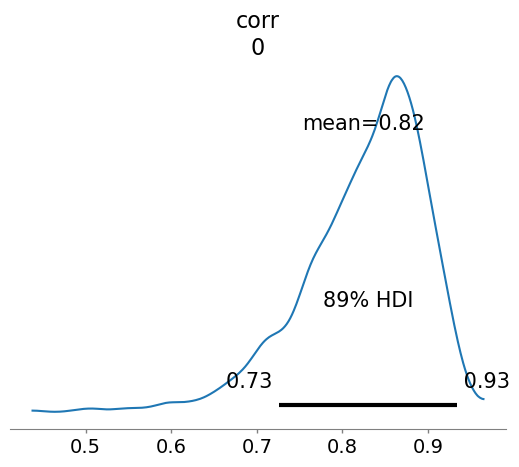

In [17]:
az.plot_posterior(idata_SAHcov, var_names=['corr'])

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Given some observed heights for a new sample of boys, how would you expect this estimated correlation to influence your predictions for their heights at unobserved ages? Feel free to base your answer off of a visualization of the entire posterior estimate of the correlation or use the mean value from a summary table. However, clearly state what estimated value you are using.

__Answer:__

Suppose we estimate the correlation to be 0.8, indicating a moderate positive relationship between the intercept and the slope. Based on this estimate, we would expect that, given a boy's height, taller boys would have faster growth rates, and therefore we would predict that they would be taller in future years.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3 (10 points).** Use `scipy.stats.multivariate_normal.rvs()` to simulate a new sample of boys (represented by their observed heights at each age), based upon the posterior mean values of the parameter estimates above. That is, try to simulate varying intercepts and slopes, using the relevant parameter estimates, and then **plot the predicted trends of observed height on age with one trend for each simulated boy you produce**.

A sample of 10 simulated boys is plenty, to illustrate the lesson. You can ignore uncertainty in the posterior, just to make the problem a little easier. But if you want to include the uncertainty about the parameters, go for it! 

Note that you can construct a variance-covariance matrix to pass as the `cov` argument to `scipy.stats.multivariate_normal.rvs()` with with code similar to the following:

`S = numpy.array( [[ sa**2 , sa*sb*rho] , [sa*sb*rho , sb**2] ])`

where `sa` is the standard deviation of the first variable, `sb` is the standard deviation of the second variable, and `rho` is the correlation between them.

This question does not require any discussion component.

_Type your answer here, replacing this text._

In [19]:
# Write code here
from scipy.stats import multivariate_normal

print("Mean of intercept:", az.summary(idata_SAHcov, var_names=["a"])["mean"].mean())
print("Mean of slope:", az.summary(idata_SAHcov, var_names=["b"])["mean"].mean())

print("Std of intercept:", az.summary(idata_SAHcov, var_names=["a"])["sd"].mean())
print("Std of slope:", az.summary(idata_SAHcov, var_names=["b"])["sd"].mean())

print("corr:", corr_values.mean())

Mean of intercept: 149.37207692307692
Mean of slope: 6.521384615384615
Std of intercept: 0.22161538461538463
Std of slope: 0.33503846153846156
corr: 0.8242519449045305


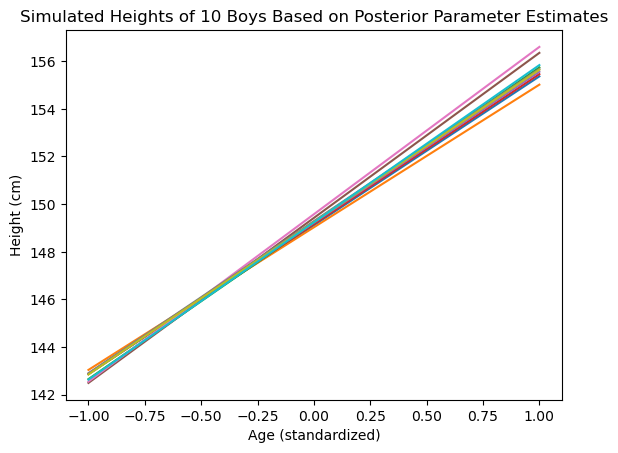

In [20]:
sa = 0.22
sb = 0.33
rho = 0.82

S = np.array([[sa**2, sa*sb*rho], [sa*sb*rho, sb**2]])

simulated_params = multivariate_normal.rvs(mean=[149.37, 6.52], cov=S, size=10)

ages = np.arange(-1, 2)

for params in simulated_params:
    intercept, slope = params
    heights = intercept + slope * ages
    plt.plot(ages, heights, label=f"Simulated boy")

plt.xlabel("Age (standardized)")
plt.ylabel("Height (cm)")
plt.title("Simulated Heights of 10 Boys Based on Posterior Parameter Estimates")
plt.show()

In [21]:
grader.check("q3")

q3 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)